In [1]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/triyuliannibasukie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseV

In [2]:
tweets = pd.read_excel('11Apr_to_30Apr_Data.xlsx')
tweets.head()

,Unnamed: 0,created_at,id_str,user_name,user_id,in_reply_to_status_id_str,in_reply_to_username,like_count,full_text
0,0,2022-04-11 23:59:55+00:00,1513668195273600000,Chance178,139130531,NaN,NaN,1,Inside Johnny Depp and Amber Heard's legal bat...
1,1,2022-04-11 23:59:40+00:00,1513668133936049920,Big_City_Radio,943105000000000000,NaN,NaN,0,Inside Johnny Depp and Amber Heard's legal bat...
2,2,2022-04-11 23:59:38+00:00,1513668125975200000,BerkleyBearNews,787546010,NaN,NaN,0,Inside Johnny Depp and Amber Heard's legal bat...
3,3,2022-04-11 23:59:08+00:00,1513668001127660032,xalfeed,9355842,NaN,NaN,0,BBC News - US &amp; Canada: Inside Johnny Depp...
4,4,2022-04-11 23:57:41+00:00,1513667635816320000,SNSDEIDADES,2742889411,NaN,NaN,5,Los fans de Amber heard be like #JusticeForJoh...


In [3]:
df = tweets.filter(['full_text', "created_at"], axis=1)
# df1 = df[df["Language"] == "en"]
df_jan = df[(df['created_at'] > '2022-04-18') & (df['created_at'] < '2022-05-01')]
df2 = df_jan.dropna()
df2

,full_text,created_at
23485,@MailOnline Amber Heard is making the MeToo mo...,2022-04-18 23:58:56+00:00
23486,Amber Heard leaves court after second day of D...,2022-04-18 23:58:13+00:00
23487,Now feminists goin to yell and defend #Amberhe...,2022-04-18 23:57:42+00:00
23488,@Mary15589635 @RealCandaceO @realamberheard Am...,2022-04-18 23:56:40+00:00
23489,Just a peak at the TRUE faces of Amber Heard.\...,2022-04-18 23:56:18+00:00
...,...,...
86158,@duty2warn you didnt show AOC response where s...,2022-04-30 12:19:28+00:00
86159,@vibezmari If ever there was a case to remind ...,2022-04-30 12:18:59+00:00
86160,@MailOnline @danwootton Dan Wootton wrote and ...,2022-04-30 12:18:57+00:00
86161,How much is Amber Heard’s Net Worth\n\nAmber H...,2022-04-30 12:18:54+00:00


# Data cleaning

In [4]:
# Remove non-English words

# remove hashtags 
df2['clean_text']  = df2['full_text'].map(lambda x: re.sub("#[A-Za-z0-9_]+", " ", str(x)))

# remove mentions
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("@[A-Za-z0-9_]+"," ", str(x)))

# remove links
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub(r"http\S+"," ", str(x)))

# remove "&amp"
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("&amp"," ", str(x)))

# remove punc 
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))

# lower case
df2['clean_text']  = df2['clean_text'].apply(lambda x: x.lower())

# remove amber heard and johnny depp
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("amber","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("heard","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("johnny","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("depp","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("ah","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("jd","", str(x)))

# tokenize
df2['clean_text']  = [word_tokenize(row) for row in df2['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df2['clean_text']  = df2['clean_text'].apply(lambda x: remove_stopwords(x))

In [5]:
df2.head()

,full_text,created_at,clean_text
23485,@MailOnline Amber Heard is making the MeToo mo...,2022-04-18 23:58:56+00:00,"[making, metoo, movement, look, really, bad, t..."
23486,Amber Heard leaves court after second day of D...,2022-04-18 23:58:13+00:00,"[leaves, court, second, day, libel, trial]"
23487,Now feminists goin to yell and defend #Amberhe...,2022-04-18 23:57:42+00:00,"[feminists, goin, yell, defend, lies]"
23488,@Mary15589635 @RealCandaceO @realamberheard Am...,2022-04-18 23:56:40+00:00,"[repeat, domestic, abuser, bad, unarmed, fight..."
23489,Just a peak at the TRUE faces of Amber Heard.\...,2022-04-18 23:56:18+00:00,"[peak, true, faces]"


In [6]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df2['clean_text'] = df2['clean_text'].apply(lambda x: lemmatization(x))


df2.head()

,full_text,created_at,clean_text
23485,@MailOnline Amber Heard is making the MeToo mo...,2022-04-18 23:58:56+00:00,"[metoo, movement, movement, year, woman, gain,..."
23486,Amber Heard leaves court after second day of D...,2022-04-18 23:58:13+00:00,"[court, day, libel, trial]"
23487,Now feminists goin to yell and defend #Amberhe...,2022-04-18 23:57:42+00:00,"[feminist, lie]"
23488,@Mary15589635 @RealCandaceO @realamberheard Am...,2022-04-18 23:56:40+00:00,"[abuser, fight, husband, occasion, point, abus..."
23489,Just a peak at the TRUE faces of Amber Heard.\...,2022-04-18 23:56:18+00:00,"[peak, face]"


In [7]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df2['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '


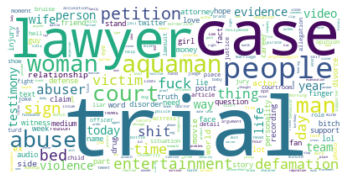

In [8]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

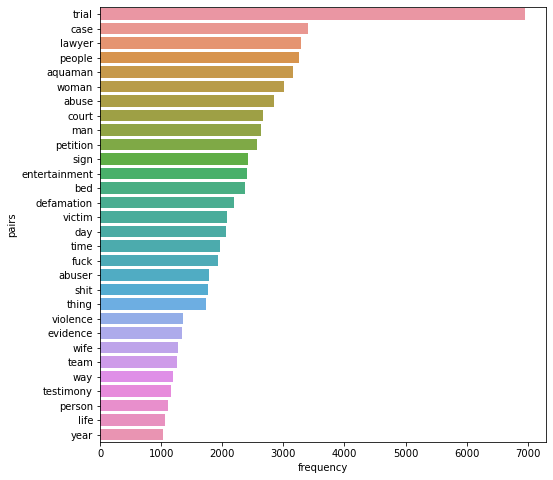

In [9]:
new_tokens = []
for i in df2["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [10]:
data_lemmatized = df2['clean_text'].tolist()
print(data_lemmatized[:3])

[['metoo', 'movement', 'movement', 'year', 'woman', 'gain', 'organization'], ['court', 'day', 'libel', 'trial'], ['feminist', 'lie']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'gain'), (1, 'metoo'), (2, 'movement'), (3, 'organization'), (4, 'woman'), (5, 'year'), (6, 'court'), (7, 'day'), (8, 'libel'), (9, 'trial'), (10, 'feminist'), (11, 'lie'), (12, 'abuse'), (13, 'abuser'), (14, 'female'), (15, 'fight'), (16, 'husband'), (17, 'matter'), (18, 'occasion'), (19, 'perpetrator'), (20, 'point'), (21, 'face'), (22, 'peak'), (23, 'fuck'), (24, 'dang'), (25, 'guy'), (26, 'information'), (27, 'umbrella'), (28, 'defamation'), (29, 'take'), (30, 'trash'), (31, 'injury'), (32, 'kipper'), (33, 'physician'), (34, 'accusation'), (35, 'hammer'), (36, 'relationship'), (37, 'revenge'), (38, 'thing'), (39, 'allll'), (40, 'charity'), (41, 'child'), (42, 'money'), (43, 'gentleman'), (44, 'lady'), (45, 'supporter'), (46, 'case'), (47, 'evidence'), (48, 'friend'), (49, 'coverage')]

Total Vocabulary Size: 5800


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [13]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [14]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.3773850490052215
Perplexity Score:  -6.772894258198834

topic number:  3
Coherence Score:  0.33611767494166117
Perplexity Score:  -6.79308867407859

topic number:  4
Coherence Score:  0.3017528026513775
Perplexity Score:  -6.855882745510049

topic number:  5
Coherence Score:  0.3068063207223053
Perplexity Score:  -6.889377828909924

topic number:  6
Coherence Score:  0.2962676228347983
Perplexity Score:  -6.899656962746478

topic number:  7
Coherence Score:  0.36720394224478176
Perplexity Score:  -6.890498964319004

topic number:  8
Coherence Score:  0.3168307507253182
Perplexity Score:  -6.944395821098295

topic number:  9
Coherence Score:  0.3072280999318864
Perplexity Score:  -6.99399638159893

topic number:  10
Coherence Score:  0.3111730612467118
Perplexity Score:  -7.108964232689065

topic number:  11
Coherence Score:  0.3096553174090848
Perplexity Score:  -7.318053231183305

topic number:  12
Coherence Score:  0.3233676488670302
Perplexity Sc

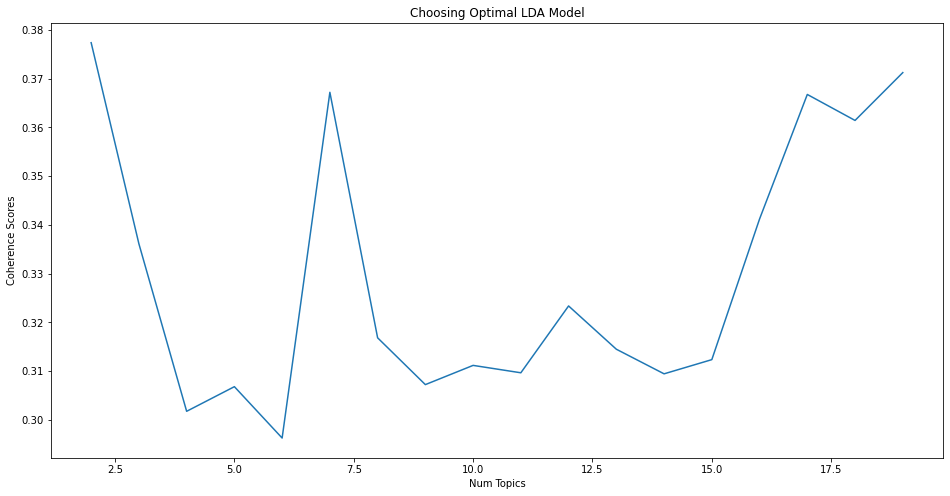

In [15]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [16]:
ntopics_des_name = 5
# We choose 5 because while the coherence score is the highest at 2 topics, 
# it may not necessarily be the most optimal number of topics having only 2 topics, especially during the trial period
# where many topics are discussed, may result in broad and unspecific topics that may not be useful 
# to analyse the hate speech of Amber Heard

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [17]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.057*"woman" + 0.049*"man" + 0.043*"victim" + 0.036*"abuse" + '
  '0.034*"trial" + 0.027*"violence" + 0.025*"abuser" + 0.020*"case" + '
  '0.017*"people" + 0.015*"wife"'),
 (1,
  '0.057*"bed" + 0.038*"shit" + 0.032*"people" + 0.027*"time" + 0.024*"movie" '
  '+ 0.021*"world" + 0.020*"side" + 0.016*"fan" + 0.013*"girl" + 0.012*"turd"'),
 (2,
  '0.039*"thing" + 0.028*"people" + 0.026*"person" + 0.021*"relationship" + '
  '0.016*"year" + 0.015*"guy" + 0.015*"story" + 0.014*"name" + 0.013*"abuse" + '
  '0.012*"bpd"'),
 (3,
  '0.055*"case" + 0.036*"court" + 0.034*"fuck" + 0.034*"team" + 0.028*"life" + '
  '0.020*"week" + 0.016*"bitch" + 0.015*"evidence" + 0.015*"time" + '
  '0.014*"officer"'),
 (4,
  '0.099*"aquaman" + 0.086*"petition" + 0.080*"entertainment" + 0.079*"sign" + '
  '0.075*"trial" + 0.058*"lawyer" + 0.026*"day" + 0.018*"disorder" + '
  '0.017*"personality" + 0.015*"video"')]


In [18]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [19]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df2)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [20]:
df2['Topic'] = topic_num

In [21]:
des_name_final = df2[['full_text', 'clean_text', 'Topic']]
des_name_final.head()

,full_text,clean_text,Topic
23485,@MailOnline Amber Heard is making the MeToo mo...,"[metoo, movement, movement, year, woman, gain,...","[0, 2, 3, 1, 4]"
23486,Amber Heard leaves court after second day of D...,"[court, day, libel, trial]","[0, 4, 3, 2, 1]"
23487,Now feminists goin to yell and defend #Amberhe...,"[feminist, lie]","[1, 0, 3, 2, 4]"
23488,@Mary15589635 @RealCandaceO @realamberheard Am...,"[abuser, fight, husband, occasion, point, abus...","[0, 3, 1, 2, 4]"
23489,Just a peak at the TRUE faces of Amber Heard.\...,"[peak, face]","[1, 2, 3, 0, 4]"


### Model Evaluation

In [22]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -6.89640282251531
Coherence Score:  0.3252898041012622


## Visualisation

In [23]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.030107  0.061464       1        1  23.293466
4      0.374531 -0.155319       2        1  21.298741
2     -0.167435 -0.180662       3        1  19.644044
1     -0.218615 -0.070498       4        1  18.113097
3      0.041625  0.345015       5        1  17.650651, topic_info=              Term         Freq        Total Category  logprob  loglift
416        aquaman  4756.000000  4756.000000  Default  30.0000  30.0000
513       petition  4122.000000  4122.000000  Default  29.0000  29.0000
512  entertainment  3853.000000  3853.000000  Default  28.0000  28.0000
514           sign  3784.000000  3784.000000  Default  27.0000  27.0000
9            trial  5366.000000  5366.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
50            part   306.354893   527.918333   Topic5  -4.8641   1.1902
52         witness   336.814134   825.875003   Topic5  -4.7693   0.8375
28      defamation   351.709543  1344.477302   Topic5  -4.7260   0.3934
21            face   245.636887   689.587582   Topic5  -5.0850   0.7022
77            jury   228.200489   387.737089   Topic5  -5.1586   1.2043

[240 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
12        1  0.773469    abuse
12        3  0.226361    abuse
13        1  0.781656   abuser
13        3  0.217973   abuser
541       1  0.998381  account
...     ...       ...      ...
99        3  0.310543     word
166       4  0.999550    world
5         1  0.289033     year
5         3  0.710865     year
783       2  0.991789  youtube

[249 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

## Word Count of Topic Keywords

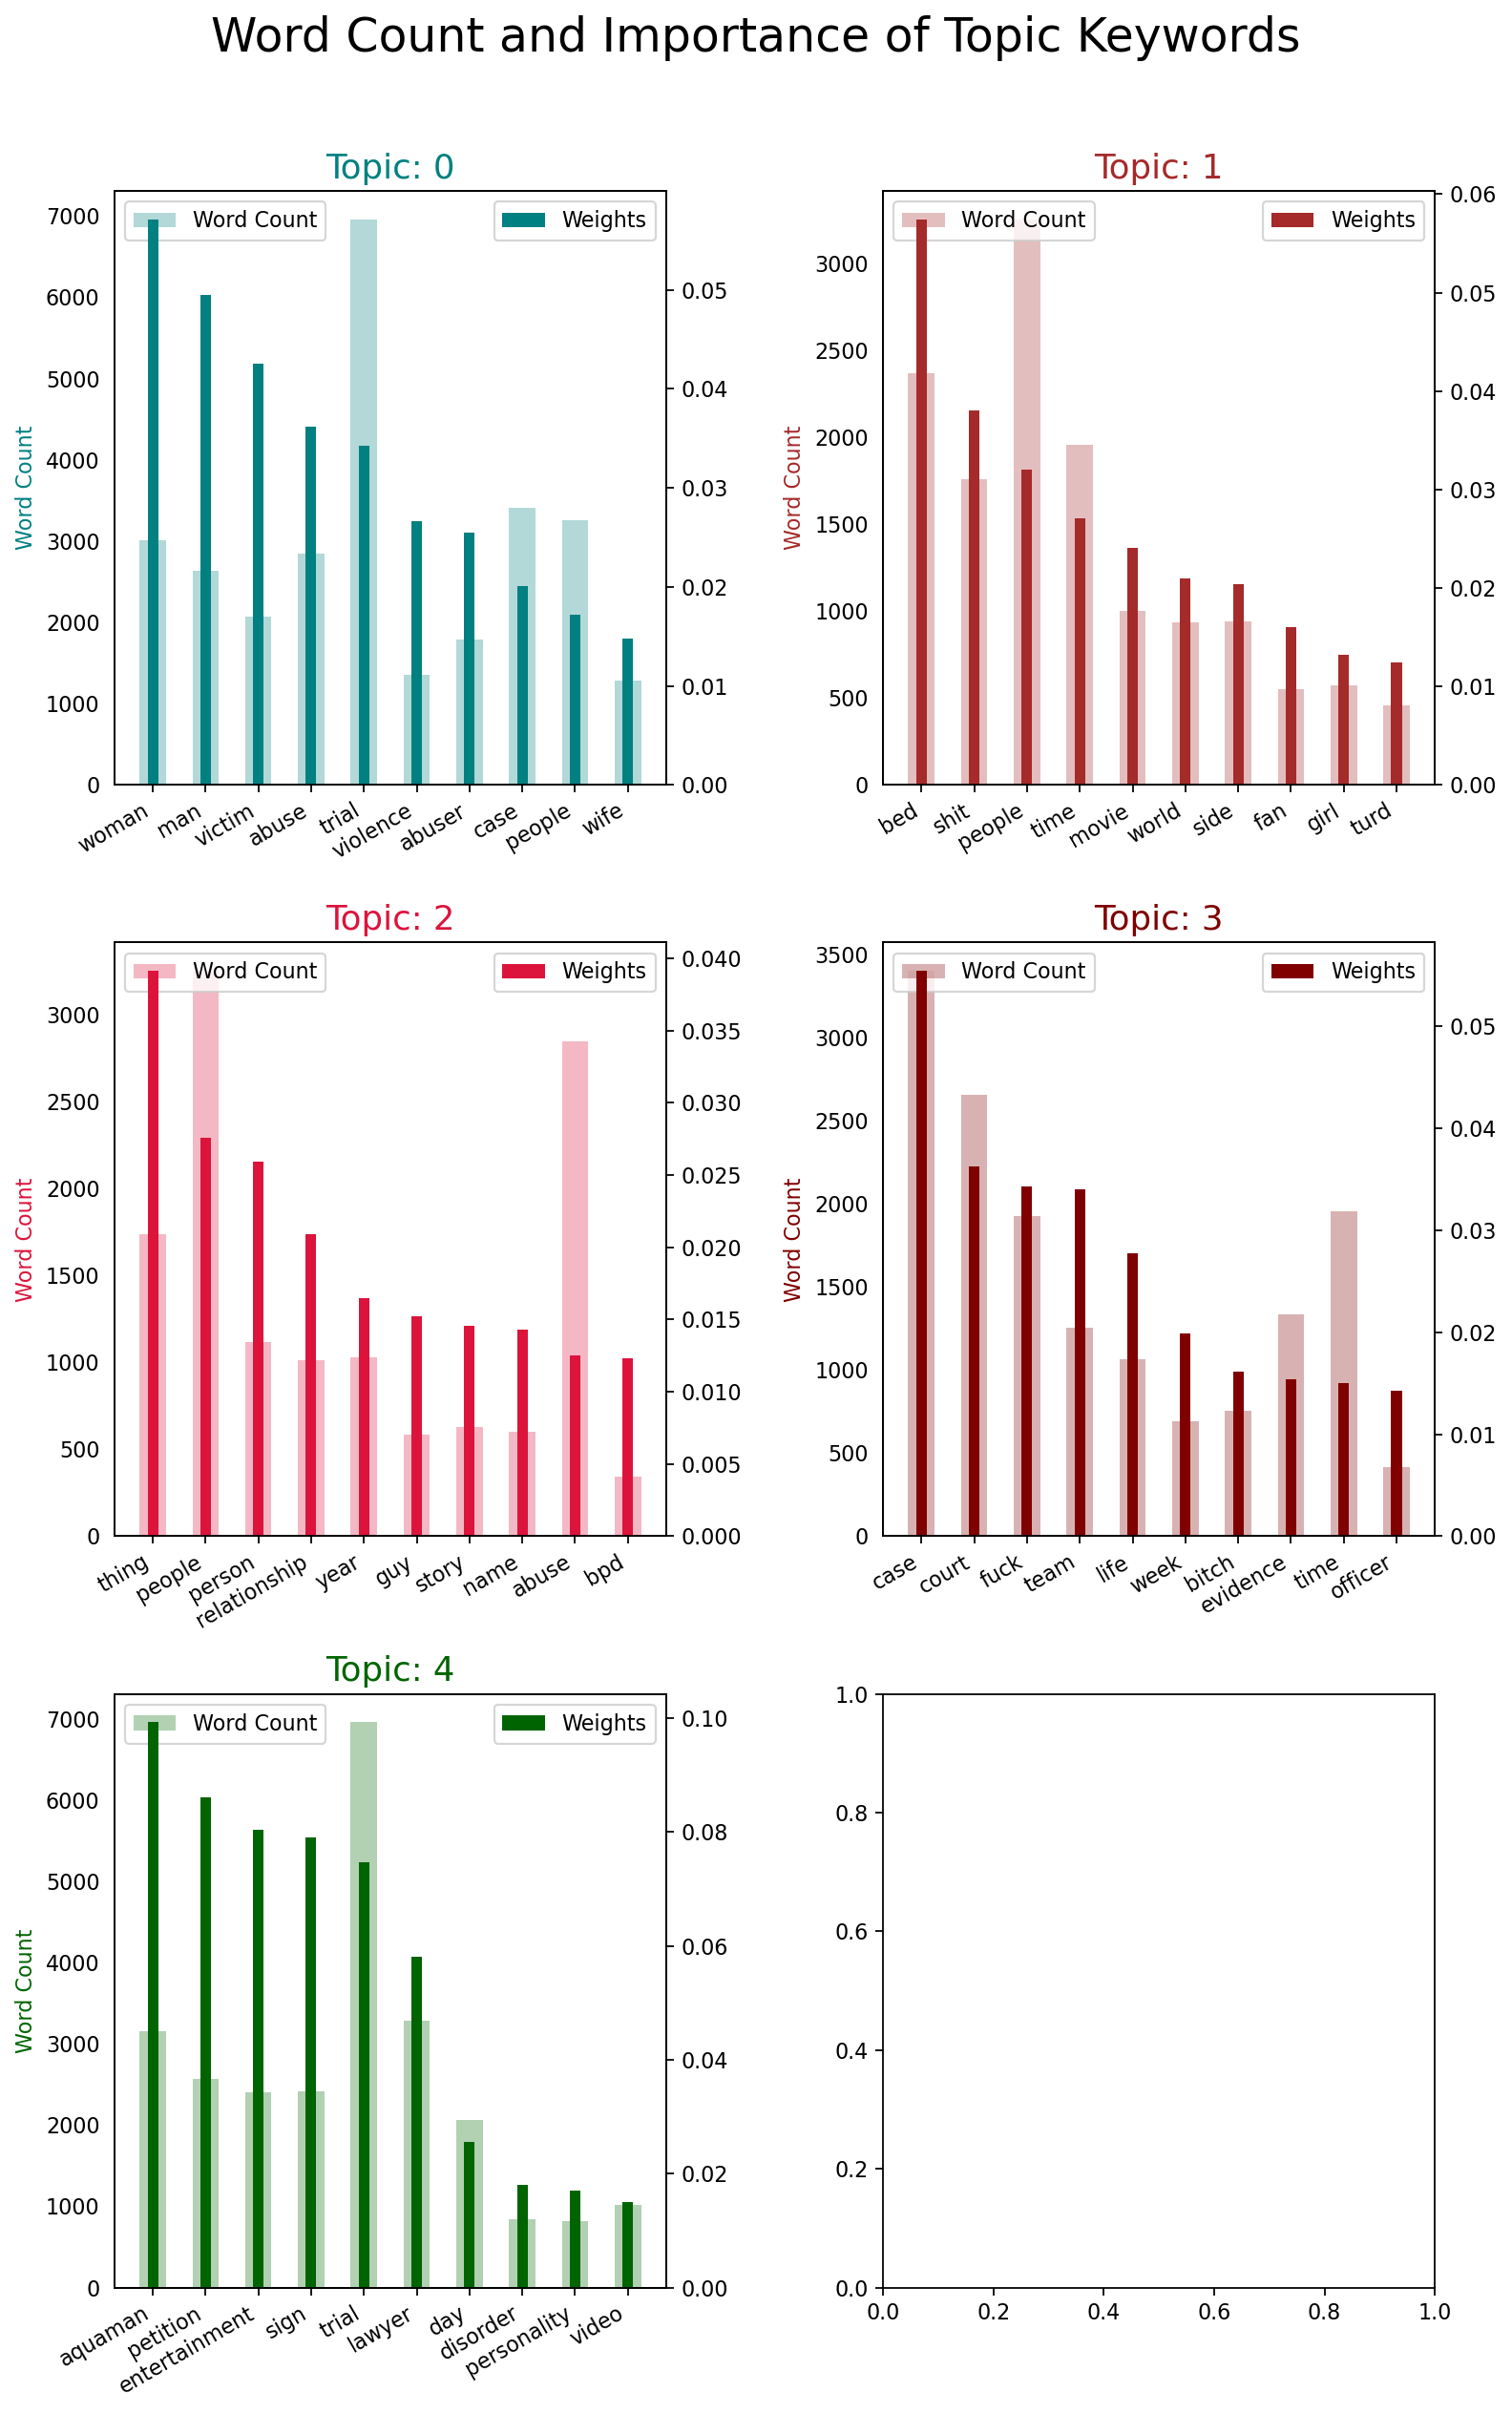

In [25]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
